In [2]:
import numpy as np
import pandas as pd
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Processing

Делаем из тыквы (безусловно, самой спелой и прекрасной) - карету: разбираемся с NA, переводим категориальные переменные в дамми, бинарные или просто заполненные категориальные.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Рабочая выборка, разбитая на train и test
train = pd.read_csv('/content/drive/MyDrive/Hackaton/train.csv', sep=';')
test = pd.read_csv('/content/drive/MyDrive/Hackaton/test.csv', sep=';')

# Дополнительные данные 

ed = pd.read_csv('/content/drive/MyDrive/Hackaton/education_mult.csv', sep=';')
ws = pd.read_csv('/content/drive/MyDrive/Hackaton/worldskills_mult.csv', sep=';')
em = pd.read_csv('/content/drive/MyDrive/Hackaton/employements_mult.csv', sep=';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#What about NA?
column_names = train.columns
for i in column_names:
    print(i,": ",train[i].isna().sum())
    
#Gender not defined for 7773 - Drop?
#No region - Drop or Assign
#

id :  0
position :  0
region :  12
industry :  0
locality :  0
locality_name :  15492
education_type :  40032
drive_licences :  184345
citizenship :  0
schedule :  0
employement_type :  0
age :  7811
gender :  7773
experience :  0
salary_desired :  0
relocation_ready :  72703
travel_ready :  69216
retraining_ready :  57126
is_worldskills_participant :  306076
has_qualifications :  303736
completeness_rate :  0
creation_date :  7
modification_date :  7
publish_date :  0
salary :  0


In [7]:
#Обработка
#Продублируем данные, чтобы не перезагружать их заново, когда что-то в обработке пойдет не так
column_names = train.columns
df=train[column_names]

#Для начала превратим категориальные переменные в дамми
#Водительские права
dl=[]
dl_cat = ['A','B','C','D','E']

for i in df['drive_licences']:
    if type(i) is str:
        dl_i=[]
        for cat in dl_cat:
            if len(re.findall(r'{}'.format(cat),i))==0:
                dl_i.append(0)
            else:
                dl_i.append(1)
        dl.append(dl_i)
    else:
        dl.append([0,0,0,0,0])
a = pd.DataFrame(dl,columns=dl_cat)
        
for cat in dl_cat:
    df[cat]=pd.Series(a[cat])


#График
dl=[]
dl_cat = ['Полный рабочий день',
'Сменный график',
'Неполный рабочий день',
'Гибкий график',
'Вахтовый метод',
'Ненормированный рабочий день']


for i in df['schedule']:
    if type(i) is str:
        dl_i=[]
        for cat in dl_cat:
            if len(re.findall(r'{}'.format(cat),i))==0:
                dl_i.append(0)
            else:
                dl_i.append(1)
        dl.append(dl_i)
    else:
        dl.append([0,0,0,0,0,0])
a = pd.DataFrame(dl,columns=dl_cat)
        
for cat in dl_cat:
    df[cat]=pd.Series(a[cat])
    
#Гражданство
no_problem=['Российская Федерация','Республика Казахстан','Республика Беларусь','Кыргызская Республика']
df['bi_citi']= np.where((df['citizenship'] == no_problem[0])|
                (df['citizenship'] == no_problem[1])|
                (df['citizenship'] == no_problem[2])|
                (df['citizenship'] == no_problem[3]),1,0)

#Образование
df['education_type']= np.where(df['education_type'].isna(),'Not defined',df['education_type'])
#т.к. есть порядок - используем лейблинг 
k=df['education_type']
ed_code=[]
for i in k:
    if i =='Высшее':
        ed_code.append(4)
    elif i =='Незаконченное высшее':
        ed_code.append(3)
    elif i =='Среднее профессиональное':
        ed_code.append(2)
    elif i =='Среднее':
        ed_code.append(1)
    else:
        ed_code.append(0)
df['education_type'] = ed_code

#Employment type и Industry
#т.к. порядка нет - прверащаем в дамми
s = pd.get_dummies(df["employement_type"], prefix = "em_", drop_first=True)
s1 = pd.get_dummies(df["industry"], drop_first=True)
s1.columns=['guard','top_mgmt','gos','mining','home','gkh','health','it','art','hr','consult','light','wood',
 'pr','mec_eng','metal','begin','edu','food_prom','sale','prod','no_qual','work_spec','eco','construc',
 'logist','travel','service','fin','chem','electro','law']
df= df.join(s)
df= df.join(s1)

#Возраст
age_median=df['age'].median(skipna = bool)
df['age']= np.where(df['age'].isna(),age_median,df['age'])
#Город
df['locality_name']= np.where(df['locality_name'].isna(),'Not defined',df['locality_name'])
#Пол
k=df['gender']
gender_code=[]
for i in k:
    if i =='Мужской':
        gender_code.append(1)
    elif i =='Женский':
        gender_code.append(0)
    else:
        gender_code.append(2)

df['gender'] = gender_code



#Готовности к переезду/путшествиям/обучениям
df['relocation_ready']= np.where(df['relocation_ready'].isna(),False,df['relocation_ready'])
df['travel_ready']= np.where(df['travel_ready'].isna(),False,df['travel_ready'])
df['retraining_ready']= np.where(df['retraining_ready'].isna(),False,df['retraining_ready'])

#Квалификация
df['is_worldskills_participant']= np.where(df['is_worldskills_participant'].isna(),False,True)
df['has_qualifications']= np.where(df['has_qualifications'].isna(),False,True)

df=df.drop(columns=['drive_licences','schedule','creation_date', 'modification_date', 'publish_date','locality'])

In [8]:
df.head(3)

,id,position,region,industry,locality_name,education_type,citizenship,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,salary,A,B,C,D,E,Полный рабочий день,Сменный график,Неполный рабочий день,Гибкий график,Вахтовый метод,Ненормированный рабочий день,bi_citi,em__Полная занятость,em__Сезонная,em__Стажировка,em__Удаленная,em__Частичная занятость,guard,top_mgmt,gos,mining,home,gkh,health,it,art,hr,consult,light,wood,pr,mec_eng,metal,begin,edu,food_prom,sale,prod,no_qual,work_spec,eco,construc,logist,travel,service,fin,chem,electro,law
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",Тула,3,Российская Федерация,Полная занятость,21.0,1,3,35000,False,False,True,False,False,64.0,37500,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",Барнаул,4,Российская Федерация,Полная занятость,26.0,0,4,15000,False,True,True,False,False,88.0,14000,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",Димитровград,4,Российская Федерация,Полная занятость,36.0,0,12,20000,False,False,True,False,False,78.0,24600,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Пробуем достать позицию

In [9]:
k=df['position']
l=[]
for i in k:
    l.append(i.split(",")[0].lower().replace('[^\w\s]','').strip())

In [10]:
len(set(l))

37768

In [11]:
from gensim import models
from gensim import corpora
import nltk

#Уберем ненужные символы, но не цифры
k_re=[]
for i in range(len(k)):
    result_k=re.findall(r'[А-я0-9]+',k[i])
    result_k=' '.join(result_k)
    k_re.append(result_k)

#Tokenizer через пробел
tokenizer = nltk.tokenize.WhitespaceTokenizer()
doc = [tokenizer.tokenize(job) for job in k_re]


In [15]:
#!pip install pymorphy2

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 8.2MB 7.7MB/s 


In [16]:
#Lemmatize
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='ru')
doc_lem = [[morph.parse(token)[0].normal_form for token in title] for title in doc]
doc_lem[0:5]

[['специалист'],
 ['лаборант'],
 ['специалист', 'администратор', 'бухгалтер', 'экономист'],
 ['специалист'],
 ['инструктор', 'по', 'плавание']]

In [18]:
#Уберем стоп слова: предлоги,междометия, местоимения и т.д.
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('russian'))

jobs = [[word for word in job if word not in stopwords] for job in doc_lem]
jobs= [[word for word in job if (len(word)>1)|(re.findall(r'[А-я]',word)==[])] for job in jobs]
jobs[0:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['специалист'],
 ['лаборант'],
 ['специалист', 'администратор', 'бухгалтер', 'экономист'],
 ['специалист'],
 ['инструктор', 'плавание']]

In [19]:
from gensim import corpora,models
dictionary = corpora.Dictionary(jobs)
corpus = [dictionary.doc2bow(text) for text in jobs]
tfidf_model = models.TfidfModel(corpus)
tfidf = tfidf_model[corpus]
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=20)
lsi.print_topics(num_words=5)

[(0,
  '0.987*"специалист" + 0.095*"менеджер" + 0.076*"бухгалтер" + 0.054*"кадр" + 0.041*"администратор"'),
 (1,
  '-0.920*"бухгалтер" + -0.313*"менеджер" + -0.132*"экономист" + -0.124*"администратор" + 0.115*"специалист"'),
 (2,
  '-0.876*"менеджер" + 0.353*"бухгалтер" + -0.281*"администратор" + -0.087*"продажа" + 0.073*"специалист"'),
 (3,
  '-0.844*"администратор" + -0.403*"продавец" + 0.317*"менеджер" + -0.090*"консультант" + -0.076*"кассир"'),
 (4,
  '0.874*"продавец" + -0.424*"администратор" + 0.188*"консультант" + 0.120*"кассир" + 0.057*"менеджер"'),
 (5,
  '-0.990*"водитель" + -0.122*"автомобиль" + -0.052*"категория" + -0.027*"погрузчик" + -0.025*"экспедитор"'),
 (6,
  '-0.994*"инженер" + -0.041*"главный" + -0.041*"механик" + -0.037*"технолог" + -0.030*"пто"'),
 (7,
  '-0.989*"экономист" + 0.133*"бухгалтер" + 0.034*"менеджер" + 0.025*"инженер" + -0.024*"юрист"'),
 (8,
  '-0.984*"юрист" + -0.139*"помощник" + -0.066*"юрисконсульт" + -0.061*"руководитель" + -0.038*"секретарь"'),
 

In [20]:
#Присваиваем топики каждой позиции
corpus_lsi = lsi[tfidf]

topics=[]
s=0
for pos in corpus_lsi:
    weights=[]
    for topic in pos:
        weights.append(topic[1])
    if not weights:
        topics.append(0)
    else:
        index=weights.index(max(weights))
        topics.append(pos[index][0])
len(topics)

306270

In [21]:
df['pos_topic']=topics

In [22]:
#What about NA again?
for i in df.columns:
    print(i,": ",df[i].isna().sum())

id :  0
position :  0
region :  12
industry :  0
locality_name :  0
education_type :  0
citizenship :  0
employement_type :  0
age :  0
gender :  0
experience :  0
salary_desired :  0
relocation_ready :  0
travel_ready :  0
retraining_ready :  0
is_worldskills_participant :  0
has_qualifications :  0
completeness_rate :  0
salary :  0
A :  0
B :  0
C :  0
D :  0
E :  0
Полный рабочий день :  0
Сменный график :  0
Неполный рабочий день :  0
Гибкий график :  0
Вахтовый метод :  0
Ненормированный рабочий день :  0
bi_citi :  0
em__Полная занятость :  0
em__Сезонная :  0
em__Стажировка :  0
em__Удаленная :  0
em__Частичная занятость :  0
guard :  0
top_mgmt :  0
gos :  0
mining :  0
home :  0
gkh :  0
health :  0
it :  0
art :  0
hr :  0
consult :  0
light :  0
wood :  0
pr :  0
mec_eng :  0
metal :  0
begin :  0
edu :  0
food_prom :  0
sale :  0
prod :  0
no_qual :  0
work_spec :  0
eco :  0
construc :  0
logist :  0
travel :  0
service :  0
fin :  0
chem :  0
electro :  0
law :  0
pos_to

In [23]:
df.head(3)

,id,position,region,industry,locality_name,education_type,citizenship,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,salary,A,B,C,D,E,Полный рабочий день,Сменный график,Неполный рабочий день,Гибкий график,Вахтовый метод,Ненормированный рабочий день,bi_citi,em__Полная занятость,em__Сезонная,em__Стажировка,em__Удаленная,em__Частичная занятость,guard,top_mgmt,gos,mining,home,gkh,health,it,art,hr,consult,light,wood,pr,mec_eng,metal,begin,edu,food_prom,sale,prod,no_qual,work_spec,eco,construc,logist,travel,service,fin,chem,electro,law,pos_topic
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",Тула,3,Российская Федерация,Полная занятость,21.0,1,3,35000,False,False,True,False,False,64.0,37500,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",Барнаул,4,Российская Федерация,Полная занятость,26.0,0,4,15000,False,True,True,False,False,88.0,14000,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",Димитровград,4,Российская Федерация,Полная занятость,36.0,0,12,20000,False,False,True,False,False,78.0,24600,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Additional Data

Есть подозрение, что вуз имеет значение. Мы выкачали данные о рейтингах вузов, попытаемся соединить их с теми, что есть в нашей базе.

In [25]:
#Подгружаем данные, скачанные с помощью файла Scrapping
uni = pd.read_csv('/content/drive/MyDrive/Hackaton/uni_russia_ranks.csv', sep=',')
short=[]
full=[]
for i in uni['title']:
    a = i.split("–")
    if len(a)>1:
        short.append(a[0])
        full.append(a[1])
    else:
        short.append("no")
        full.append(a[0])

uni['full']=full
uni['full']=uni['full'].str.lower()
uni['full']=uni['full'].str.replace('[^\w\s]','')
uni['full']=uni['full'].str.strip()
uni['short']=short
uni['short']=uni['short'].str.lower()
uni['short']=uni['short'].str.replace('[^\w\s]','')
uni['short']=uni['short'].str.strip()
uni.head()

,title,city,rank,rating,full,short
0,Первый МГМУ имени И.М. Сеченова – Первый Моско...,Москва,13-ый,552,первый московский государственный медицинский ...,первый мгму имени им сеченова
1,СПбПУ – Санкт-Петербургский политехнический ун...,Санкт-Петербург,14-ый,548,санктпетербургский политехнический университет...,спбпу
2,УрФУ имени Б.Н. Ельцина – Уральский федеральны...,Екатеринбург,15-ый,547,уральский федеральный университет имени бн ель...,урфу имени бн ельцина
3,РУДН – Российский университет дружбы народов,Москва,16-ый,546,российский университет дружбы народов,рудн
4,РГУ нефти и газа имени И.М. Губкина – Российск...,Москва,17-ый,542,российский государственный университет нефти и...,ргу нефти и газа имени им губкина


In [26]:
education = ed[ed.columns]
education['institution']=education['institution'].str.lower()
education['institution']=education['institution'].str.strip()
education['institution']=education['institution'].str.replace('[^\w\s]','')
education.columns=['id', 'graduation_year', 'full', 'description']
#Пробуем объединить по полному названию
education = pd.merge(education, uni, how='left', on="full")
#Пробуем объединить по полному названию, но вместо "имени" используем им
uni["full"]=uni['full'].str.replace(r'имени','им')
education = pd.merge(education, uni, how='left', on="full")
#Пробуем объединить по короткому названию
education.columns=['id', 'graduation_year', 'short', 'description', 'title_x', 'city_x', 'rank_x', 'rating_x', 'short_x', 'title_y', 'city_y', 'rank_y', 'rating_y', 'short_y']
education = pd.merge(education, uni, how='left', on="short")
education.head()

,id,graduation_year,short,description,title_x,city_x,rank_x,rating_x,short_x,title_y,city_y,rank_y,rating_y,short_y,title,city,rank,rating,full
0,0.0,2022.0,тульский государственный университет,NaN,ТулГУ – Тульский государственный университет,Тула,55-ый,493.0,тулгу,ТулГУ – Тульский государственный университет,Тула,55-ый,493.0,тулгу,NaN,NaN,NaN,NaN,NaN
1,1.0,2016.0,алтайский государственный аграрный университет,NaN,АГАУ – Алтайский государственный аграрный унив...,Барнаул,382-ой,380.0,агау,АГАУ – Алтайский государственный аграрный унив...,Барнаул,382-ой,380.0,агау,NaN,NaN,NaN,NaN,NaN
2,10.0,2018.0,байкальский государственный университет г иркутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,2014.0,якутский колледж инновационных технологий,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100.0,2009.0,московский гуманитарный университет,NaN,МосГУ – Московский гуманитарный университет,Москва,285-ый,400.0,мосгу,МосГУ – Московский гуманитарный университет,Москва,285-ый,400.0,мосгу,NaN,NaN,NaN,NaN,NaN


In [27]:
#Оставляем то, что нашли:
k=education[['id','graduation_year','short','rank_x','rating_x','rank_y','rating_y','rank','rating']]
def rank(row):
    if type(row['rank_x']) is str:
        return row['rank_x']
    else:
        if type(row['rank_y']) is str:
            return row['rank_y']
        else:
            return row['rank']
def rat(row):
    if row['rating_x'] >0:
        return row['rating_x']
    else:
        if row['rating_y'] >0:
            return row['rating_y']
        else:
            return row['rating']

k['u_rank'] = k.apply(rank, axis=1)
k['u_rating'] = k.apply(rat, axis=1)
k['u_rank']= np.where(k['u_rank'].isna(),0,k['u_rank'])
k['u_rating']= np.where(k['u_rating'].isna(),0,k['u_rating'])

k=k[['id','graduation_year','short','u_rank','u_rating']]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [28]:
k.columns=['id', 'graduation_year', 'institution', 'u_rank', 'u_rating']
univers=k.copy()
print("Нашли университетов: ",len(np.array(k.u_rank[(k.u_rank!=0)]))/len(k))
univers.head()

Нашли университетов:  0.27057780913498564


,id,graduation_year,institution,u_rank,u_rating
0,0.0,2022.0,тульский государственный университет,55-ый,493.0
1,1.0,2016.0,алтайский государственный аграрный университет,382-ой,380.0
2,10.0,2018.0,байкальский государственный университет г иркутск,0,0.0
3,10.0,2014.0,якутский колледж инновационных технологий,0,0.0
4,100.0,2009.0,московский гуманитарный университет,285-ый,400.0


## Modeling

In [29]:
df.head(2)

,id,position,region,industry,locality_name,education_type,citizenship,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,salary,A,B,C,D,E,Полный рабочий день,Сменный график,Неполный рабочий день,Гибкий график,Вахтовый метод,Ненормированный рабочий день,bi_citi,em__Полная занятость,em__Сезонная,em__Стажировка,em__Удаленная,em__Частичная занятость,guard,top_mgmt,gos,mining,home,gkh,health,it,art,hr,consult,light,wood,pr,mec_eng,metal,begin,edu,food_prom,sale,prod,no_qual,work_spec,eco,construc,logist,travel,service,fin,chem,electro,law,pos_topic
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",Тула,3,Российская Федерация,Полная занятость,21.0,1,3,35000,False,False,True,False,False,64.0,37500,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",Барнаул,4,Российская Федерация,Полная занятость,26.0,0,4,15000,False,True,True,False,False,88.0,14000,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11


In [30]:
df.columns

Index(['id', 'position', 'region', 'industry', 'locality_name', 'education_type', 'citizenship', 'employement_type', 'age', 'gender', 'experience', 'salary_desired', 'relocation_ready', 'travel_ready', 'retraining_ready', 'is_worldskills_participant', 'has_qualifications', 'completeness_rate', 'salary', 'A', 'B', 'C', 'D', 'E', 'Полный рабочий день', 'Сменный график', 'Неполный рабочий день', 'Гибкий график', 'Вахтовый метод', 'Ненормированный рабочий день', 'bi_citi', 'em__Полная занятость', 'em__Сезонная', 'em__Стажировка', 'em__Удаленная', 'em__Частичная занятость', 'guard', 'top_mgmt', 'gos', 'mining', 'home', 'gkh', 'health', 'it', 'art', 'hr', 'consult', 'light', 'wood', 'pr', 'mec_eng', 'metal', 'begin', 'edu', 'food_prom', 'sale', 'prod', 'no_qual', 'work_spec', 'eco', 'construc', 'logist', 'travel', 'service', 'fin', 'chem', 'electro', 'law', 'pos_topic'], dtype='object')

In [31]:
attempt0=df.drop(columns=['position','region','industry','locality_name','citizenship','employement_type']).copy()

logs=['relocation_ready', 'travel_ready', 'retraining_ready','A', 'B', 'C', 'D', 'E', 
      'Полный рабочий день', 'Сменный график', 'Неполный рабочий день', 'Гибкий график', 'Вахтовый метод',
      'Ненормированный рабочий день', 'bi_citi', 'em__Полная занятость', 'em__Сезонная', 'em__Стажировка',
      'em__Удаленная', 'em__Частичная занятость', 'guard', 'top_mgmt', 'gos', 'mining', 'home', 'gkh', 'health',
      'it', 'art', 'hr', 'consult', 'light', 'wood', 'pr', 'mec_eng', 'metal', 'begin', 'edu', 'food_prom', 'sale',
      'prod', 'no_qual', 'work_spec', 'eco', 'construc', 'logist', 'travel', 'service', 'fin', 'chem', 'electro',
      'law']

for i in logs:
    attempt0[i] = attempt0[i].astype('bool')    

#Придется убрать резюме с ошибками, например, где люди указывали вместо зп (любой другой ожидаемой цифры), текст
attempt0['age']= pd.to_numeric(attempt0['age'],errors='coerce')
attempt0['age']= np.where(np.isnan(pd.to_numeric(attempt0['age'],errors='coerce')),age_median,attempt0['age'])

experience_median=attempt0['experience'].median(skipna = bool)
attempt0['experience']= pd.to_numeric(attempt0['experience'],errors='coerce')
attempt0['experience']= np.where(np.isnan(pd.to_numeric(attempt0['experience'],errors='coerce')),experience_median,attempt0['experience'])

sd_median=attempt0['salary_desired'].median(skipna = bool)
attempt0['salary_desired']= pd.to_numeric(attempt0['salary_desired'],errors='coerce')
attempt0['salary_desired']= np.where(np.isnan(pd.to_numeric(attempt0['salary_desired'],errors='coerce')),sd_median,attempt0['salary_desired'])
attempt0['salary']= pd.to_numeric(attempt0['salary'])
#Пока дропнем переменные с категорией

attempt0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306270 entries, 0 to 306269
Data columns (total 63 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            306270 non-null  int64  
 1   education_type                306270 non-null  int64  
 2   age                           306270 non-null  float64
 3   gender                        306270 non-null  int64  
 4   experience                    306270 non-null  float64
 5   salary_desired                306270 non-null  float64
 6   relocation_ready              306270 non-null  bool   
 7   travel_ready                  306270 non-null  bool   
 8   retraining_ready              306270 non-null  bool   
 9   is_worldskills_participant    306270 non-null  bool   
 10  has_qualifications            306270 non-null  bool   
 11  completeness_rate             306270 non-null  float64
 12  salary                        306270 non-nul

In [32]:
attempt0.to_csv('attempt0_train.csv', sep=',', index=False)

In [33]:
#Разбиение на нашу тестовую и обучающую
y = attempt0.iloc[:,12]
X = attempt0.drop(columns="salary")
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

### Базовое дерево решений

In [34]:
#Банальное дерево решений
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
tree1 = DecisionTreeRegressor(max_depth=9)
tree1.fit(X_train,y_train)

y_pred = tree1.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))
print("R^2: ",tree1.score(X_test,y_test))

RLSME:  1.100073265208522
R^2:  0.3035505447219673


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.310473 to fit



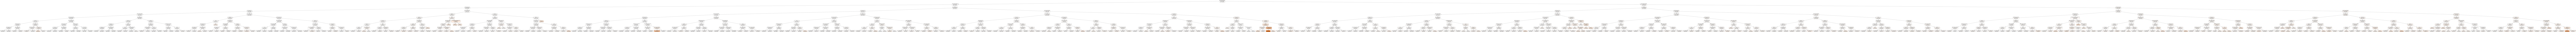

In [34]:
#Визуализация дерева
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X.columns) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


### Линейная регрессия


In [35]:
#Линейная регрессия
y = attempt0.iloc[:, 12].values.reshape(-1, 1)
X = attempt0.copy()
X=X.drop(columns="salary")
col_nam=X.columns[1:]
col_nam = col_nam.insert(0,'intercept')

X =X.iloc[:,1:].values
X = np.array(X, dtype=float)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

import statsmodels.api as sm
#добавим столбец с 1, чтобы посчитался свободный коэффициент
X_train0 = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
smm = sm.OLS(y_train, X_train0)
X = np.column_stack(col_nam)
res = smm.fit()
y_pred= res.predict(X_test)


print("RLSME: ", mean_squared_log_error(y_test, y_pred))
res.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


RLSME:  1.1128340558770595


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1430.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:42:02   Log-Likelihood:            -2.3933e+06
No. Observations:              204180   AIC:                         4.787e+06
Df Residuals:                  204118   BIC:                         4.787e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.286e+04   1747.323      7.362      0.000    9439.623    1.63e+04
x1          1834.4017     56.122     32.686      0.000    1724.405    1944.399
x2            -1.8366      5.990     -0.307      0.759     -13.576       9.903
x3          4301.4099    147.490     29.164      0.000    4012.333    4590.486
x4           261.9159     10.322     25.374      0.000     241.685     282.147
x5             0.4479      0.003    137.611      0.000       0.442       0.454
x6          1.438e+04    211.041     68.143      0.000     1.4e+04    1.48e+04
x7          4716.4970    162.867     28.959      0.000    4397.282    5035.712
x8          1348.0585    162.402      8.301      0.000    1029.755    1666.362
x9         -5041.5326   2540.182     -1.985      0.047      -1e+04     -62.837
x10        -1743.7347    736.703     -2.367      0.018   -3187.654    -299.815
x11           19.4783      4.474      4.353      0.000      10.709      28.248
x12         2019.0704    406.979      4.961      0.000    1221.401    2816.740
x13         2167.8959    157.923     13.728      0.000    1858.370    2477.422
x14         3030.5803    288.671     10.498      0.000    2464.791    3596.369
x15         1305.7701    642.182      2.033      0.042      47.109    2564.431
x16         -139.0076    699.564     -0.199      0.842   -1510.137    1232.122
x17         1175.6759    277.856      4.231      0.000     631.085    1720.267
x18        -1160.7625    218.562     -5.311      0.000   -1589.138    -732.387
x19          -86.8183    327.450     -0.265      0.791    -728.613     554.976
x20         -747.3790    294.822     -2.535      0.011   -1325.222    -169.536
x21         1.953e+04    357.069     54.697      0.000    1.88e+04    2.02e+04
x22         1440.0606    481.847      2.989      0.003     495.653    2384.468
x23        -6264.2227   1416.348     -4.423      0.000   -9040.229   -3488.216
x24         1468.0016    909.456      1.614      0.106    -314.511    3250.514
x25        -3547.1926   1569.058     -2.261      0.024   -6622.508    -471.877
x26         1159.0213   2168.827      0.534      0.593   -3091.827    5409.870
x27         2631.1162   1089.940      2.414      0.016     494.861    4767.372
x28          424.6790    956.322      0.444      0.657   -1449.688    2299.046
x29        -3462.4251    487.727     -7.099      0.000   -4418.358   -2506.492
x30         1.227e+04    545.693     22.492      0.000    1.12e+04    1.33e+04
x31          750.4157    320.341      2.343      0.019     122.555    1378.276
x32          1.74e+04    483.469     35.999      0.000    1.65e+04    1.84e+04
x33        -2001.5192    946.580     -2.114      0.034   -3856.793    -146.246
x34         1946.9843    542.343      3.590      0.000     884.005    3009.963
x35         3150.7172    396.321      7.950      0.000    2373.937    3927.497
x3

In [38]:
#Regression with Regularization 
y = attempt0.iloc[:, 12].values.reshape(-1, 1)
X = attempt0.copy()
X=X.drop(columns="salary")
X =X.iloc[:,1:].values
X = np.array(X, dtype=float)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

#Linear Regression Ridge
from sklearn.linear_model import Ridge
met_linridge = Ridge(alpha=130)
#Linear Regression Lasso
from sklearn.linear_model import Lasso
met_linlasso = Lasso(alpha=40)


#Строим модель на тренировочных данных. 
met_linridge.fit(X_train,y_train)
y_pred = met_linridge.predict(X_test)
y_tr_pred=met_linridge.predict(X_train)
y_tr_pred=np.where(y_tr_pred<0,y_tr_pred.mean(),y_tr_pred)

#Строим модель на тренировочных данных. 
met_linlasso.fit(X_train,y_train)
y_pred_l = met_linlasso.predict(X_test)
y_tr_pred_l=met_linlasso.predict(X_train)
y_tr_pred_l=np.where(y_tr_pred_l<0,y_tr_pred.mean(),y_tr_pred_l)

print("Результат на тестовой:", mean_squared_log_error(y_test, y_pred),
      "Результат на train:", mean_squared_log_error(y_train, y_tr_pred))
print("_____________________")
print("Результат на тестовой:", mean_squared_log_error(y_test, y_pred_l),
      "Результат на train:", mean_squared_log_error(y_train, y_tr_pred_l))



Результат на тестовой: 1.112804971408073 Результат на train: 1.1267166325228541
_____________________
Результат на тестовой: 1.112493768500543 Результат на train: 1.1265301269358738


### Ансамбли


In [39]:
#Разбиение на нашу тестовую и обучающую
y = attempt0.iloc[:,12]
X = attempt0.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)
#еще одна модификация Extra Trees (где точки разделения в дереве тоже выбираются случайно, а не оптимизируя предсказания)
from sklearn.ensemble import ExtraTreesRegressor
modelET = ExtraTreesRegressor(n_estimators=100,max_depth=12)
modelET.fit(X_train, y_train)
y_pred = modelET.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.100799440048058


In [40]:
#Адаптивный бустинг
from sklearn.ensemble import AdaBoostRegressor
modelAB = AdaBoostRegressor(n_estimators=100)
modelAB.fit(X_train, y_train)
y_pred = modelAB.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.2195516463829184


In [41]:
#Градиентный бустинг
from sklearn.ensemble import GradientBoostingRegressor
modelGB = GradientBoostingRegressor(n_estimators=100)
modelGB.fit(X_train, y_train)
y_pred = modelGB.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.0914398625176063


In [42]:
#Bagging
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
modelBag = BaggingRegressor(n_estimators=100, random_state=5)
modelBag.fit(X_train, y_train)
y_pred = modelBag.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.1092936725585714


In [43]:
# Вотинг - в случае регресии считает среднее
from sklearn.ensemble import VotingRegressor
modelVote = VotingRegressor(estimators=[('dt', tree1), ('gb', modelGB),('et', modelET)])
modelVote.fit(X_train,y_train)
y_pred = modelVote.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.0939748145610082


## Улучшения

Попробуем:
1. Снизить размерность: отобрать переменные
2. Попробовать модели на меньшем числе переменных
3. Добавить дополнительные данные (рейтинг вуза и кластер города)
4. Параллельно попробовать нейронные сети
5. Скалировать переменные и построить модели на нормированных данных

### Cнижение размерности


In [44]:
#RFE
# evaluate RFE for regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

estimator = DecisionTreeRegressor()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

[ True  True False  True  True  True  True  True False False  True False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True]
[ 1  1  2  1  1  1  1  1 52 40  1 12  1  4 26 23 15  5 19 13  3 20 37 27
 50 49 45 43 28 14  9 11 51 25 21 16 36 33 38 47 46 34 30 42 48 31 35  7
  6 39 24 41 10  8 32 44 17 29 22 18  1]


In [45]:
# summarize all features
for i in range(len(X_train.columns)):
  if selector.support_[i]:
    print(X.columns[i],": ",selector.ranking_[i])

education_type :  1
age :  1
experience :  1
salary_desired :  1
relocation_ready :  1
travel_ready :  1
retraining_ready :  1
completeness_rate :  1
B :  1
pos_topic :  1


PCA отказалась снижать размерность и сказала, что 99 % всей вариации можно объяснить желаемой одним фактором (на 95 % опирающимся на желаемую з/п).

In [46]:
#PCA
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=8)
fit = pca.fit(X)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)


Explained Variance: [9.99998932e-01 5.84013597e-07 3.11321150e-07 8.97158826e-08
 7.49193284e-08 3.37138889e-09 7.34048967e-10 4.56343404e-10]


In [47]:
#Univariate Selection
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
t = SelectKBest(score_func=f_regression, k=12)
fit = t.fit(X, y)
# summarize scores
print(fit.scores_)
features = fit.transform(X)

# summarize selected features
print(features[0:5,:])

[1.00997647e+04 1.38961610e+03 1.67088577e+04 9.89721404e+03
 6.74351580e+04 2.87329758e+04 2.76123144e+04 4.01181705e+03
 1.59598857e-01 4.02445911e-01 4.34308608e+03 3.00756403e+03
 1.30614066e+04 8.84887110e+03 1.24716489e+03 1.25186266e+03
 7.49860457e+02 3.47006235e+02 6.44250921e+02 5.16494019e+01
 2.33172614e+04 1.59734084e+03 2.40012566e+02 1.55157229e+03
 2.71116882e+01 9.26186769e+00 3.46060146e+00 1.57411281e+03
 1.39150936e+02 3.60657339e+03 4.28848357e-01 1.34251978e+04
 4.44068365e+02 1.94853776e+01 9.33719491e-01 1.68933979e+02
 1.87112839e+02 8.73862467e+01 1.56464327e+02 2.05707249e+02
 6.07932630e-02 5.53067871e+00 1.26262771e+02 4.78461630e+01
 2.22217176e+00 8.11889970e+02 8.66875036e+02 1.62482597e+03
 1.21621074e+03 2.63404972e+03 3.61503269e+01 1.23072582e+02
 1.73788391e+03 8.44479620e+02 1.60102940e+02 2.98422388e+02
 1.01452341e+02 9.15499042e+02 1.01882381e+03 8.76647836e+00
 1.60111035e+03]
[[3 1 3.0 35000.0 False False True 64.0 True False False False]
 [4 

In [48]:
X.head(5)
#Отобрались education type, пол,зарплата,опыт, релокейшн, тревел, ретрейнинг, заполненность, категории водительских прав.

,education_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,A,B,C,D,E,Полный рабочий день,Сменный график,Неполный рабочий день,Гибкий график,Вахтовый метод,Ненормированный рабочий день,bi_citi,em__Полная занятость,em__Сезонная,em__Стажировка,em__Удаленная,em__Частичная занятость,guard,top_mgmt,gos,mining,home,gkh,health,it,art,hr,consult,light,wood,pr,mec_eng,metal,begin,edu,food_prom,sale,prod,no_qual,work_spec,eco,construc,logist,travel,service,fin,chem,electro,law,pos_topic
0,3,21.0,1,3.0,35000.0,False,False,True,False,False,64.0,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
1,4,26.0,0,4.0,15000.0,False,True,True,False,False,88.0,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,11
2,4,36.0,0,12.0,20000.0,False,False,True,False,False,78.0,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
3,4,34.0,0,9.0,30000.0,False,False,False,False,False,91.0,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
4,0,25.0,1,1.0,40000.0,False,False,False,False,False,58.0,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17


In [ ]:
#!pip install eli5

In [52]:
#Feature Importance уже имеющихся
import eli5
feat_imp_tree = eli5.explain_weights_df(modelET, feature_names=X.columns.to_list())
feat_imp_tree[0:11]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


,feature,weight,std
0,salary_desired,0.265585,0.069249
1,relocation_ready,0.196389,0.025699
2,Вахтовый метод,0.099517,0.016644
3,gender,0.058131,0.016020
4,travel_ready,0.052948,0.010409
5,education_type,0.040357,0.006888
6,B,0.033157,0.010478
7,experience,0.030245,0.010288
8,pos_topic,0.028876,0.015245
9,completeness_rate,0.024825,0.011455


In [53]:
feat_imp_tree = eli5.explain_weights_df(modelGB, feature_names=X.columns.to_list())
feat_imp_tree[0:11]

,feature,weight,std
0,salary_desired,0.669182,0.238273
1,relocation_ready,0.089564,0.095645
2,travel_ready,0.056855,0.043364
3,Вахтовый метод,0.044808,0.084378
4,gender,0.027880,0.078890
5,education_type,0.024333,0.068956
6,completeness_rate,0.018967,0.082515
7,experience,0.018487,0.097020
8,mining,0.014671,0.076628
9,B,0.008102,0.053086


In [54]:
feat_imp_tree = eli5.explain_weights_df(tree1, feature_names=X.columns.to_list())
feat_imp_tree[0:11]

,feature,weight
0,salary_desired,0.645905
1,relocation_ready,0.080689
2,travel_ready,0.060566
3,age,0.043785
4,gender,0.034422
5,Вахтовый метод,0.027321
6,education_type,0.020423
7,completeness_rate,0.017512
8,experience,0.015854
9,mining,0.009135


### Отбираем переменные

In [55]:
chosen=['id','education_type','age','experience','salary_desired','relocation_ready','travel_ready','completeness_rate','B',
        'pos_topic','gender','Вахтовый метод','salary']
attempt1=attempt0[chosen].copy()
attempt1.head()

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,salary
0,0,3,21.0,3.0,35000.0,False,False,64.0,True,0,1,False,37500
1,1,4,26.0,4.0,15000.0,False,True,88.0,True,11,0,False,14000
2,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600
3,4,4,34.0,9.0,30000.0,False,False,91.0,True,0,0,False,16075
4,5,0,25.0,1.0,40000.0,False,False,58.0,False,17,1,False,22080


In [56]:
#Разбиение
from sklearn.metrics import mean_squared_log_error
y = attempt1.iloc[:,-1]
X = attempt1.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
modelGB = GradientBoostingRegressor(loss='lad', n_estimators=100,learning_rate=0.4,max_depth=5,random_state=0)
modelGB.fit(X_train, y_train)
y_pred = modelGB.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.0595009580614372


In [ ]:
#!pip install catboost

In [61]:
from catboost import CatBoostRegressor
#Можно и нужно подсказать бустеру, что из этого категория, т.к. это его особенность
categ=['pos_topic','gender','education_type']
for i in categ:
  X[i]=X[i].astype('category')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [ ]:
modelCB=CatBoostRegressor(iterations = 150,depth=7,one_hot_max_size=30)
modelCB.fit(X_train, y_train,categ)
y_pred = modelCB.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))
#Хуже, чем ожидалось, категоризация не особо помогла

In [63]:
#LGBM
from lightgbm import LGBMRegressor
modelLGBM=LGBMRegressor(max_depth=7,n_estimators=100,learning_rate= 0.2)
modelLGBM.fit(X_train, y_train)
y_pred = modelLGBM.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))
#Второе подтверждение, что категоризация не хелб

RLSME:  1.0893493485013643


In [65]:
#!pip install xgboost

In [66]:
#Разбиение
y = attempt1.iloc[:,-1]
X = attempt1.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [67]:
#XGBoost
from xgboost import XGBRegressor
modelXGB=XGBRegressor(n_estimators=100, max_depth=5,random_state=0,reg_lambda =10) #learning_rate=0.4,
modelXGB.fit(X_train, y_train)
y_pred = modelXGB.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))
#Тоже как-то нет

[06:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RLSME:  1.0902585671663918


### Neural Network

In [55]:
#Нейронка учится в отдельных контейнерах - следите за обновлениями

### Adding aditional data

In [68]:
attempt1.head()

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,salary
0,0,3,21.0,3.0,35000.0,False,False,64.0,True,0,1,False,37500
1,1,4,26.0,4.0,15000.0,False,True,88.0,True,11,0,False,14000
2,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600
3,4,4,34.0,9.0,30000.0,False,False,91.0,True,0,0,False,16075
4,5,0,25.0,1.0,40000.0,False,False,58.0,False,17,1,False,22080


In [70]:
#Присоединим кластер города и рейтинг университета, как доп. данные
cities=pd.read_csv('/content/drive/MyDrive/Hackaton/df_work.csv', sep=',') #отдельно сделали преобразование и сохранили
cities=cities[['id','cluster']]
un_rat=univers[['id','u_rating']]
attempt2=attempt1.copy()
attempt2 = pd.merge(attempt2, un_rat, how='left', on="id")
attempt2 = pd.merge(attempt2, cities, how='left', on="id")
attempt2['u_rating']=np.where(np.isnan(attempt2['u_rating']),0,attempt2['u_rating'])
attempt2.head(3)

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,salary,u_rating,cluster
0,0,3,21.0,3.0,35000.0,False,False,64.0,True,0,1,False,37500,493.0,8
1,1,4,26.0,4.0,15000.0,False,True,88.0,True,11,0,False,14000,380.0,4
2,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600,0.0,0


In [71]:
#Градиентный бустинг (наш фаворит)
from sklearn.metrics import mean_squared_log_error
y = attempt2.iloc[:,-3]
X = attempt2.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

from sklearn.ensemble import GradientBoostingRegressor
modelGB_ad = GradientBoostingRegressor(loss='lad', n_estimators=100,learning_rate=0.4,max_depth=6,random_state=0)
modelGB_ad.fit(X_train, y_train)
y_pred = modelGB_ad.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.0639553408651425


In [72]:
import eli5
feat_imp_tree = eli5.explain_weights_df(modelGB_ad, feature_names=X.columns.to_list())
feat_imp_tree
#Не важно, где ты получал образование, важно, что ты его получил

,feature,weight,std
0,salary_desired,0.655705,0.156722
1,cluster,0.065096,0.106950
2,travel_ready,0.057199,0.024262
3,completeness_rate,0.038425,0.073760
4,education_type,0.037437,0.046247
5,pos_topic,0.032222,0.078696
6,relocation_ready,0.025765,0.052229
7,experience,0.023970,0.246685
8,gender,0.022715,0.032295
9,age,0.015177,0.118303


In [73]:
#Градиентный бустинг, но без рейтинга университета
from sklearn.metrics import mean_squared_log_error
y = attempt2.iloc[:,-3]
X = attempt2.copy()
X = X.drop(columns=['salary','u_rating'])
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

from sklearn.ensemble import GradientBoostingRegressor
modelGB_ad = GradientBoostingRegressor(loss='lad', n_estimators=100,learning_rate=0.4,max_depth=6,random_state=0)
modelGB_ad.fit(X_train, y_train)
y_pred = modelGB_ad.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.0639743143698357


In [74]:
feat_imp_tree = eli5.explain_weights_df(modelGB_ad, feature_names=X.columns.to_list())
feat_imp_tree

,feature,weight,std
0,salary_desired,0.653809,0.138237
1,cluster,0.066678,0.084294
2,travel_ready,0.057185,0.035545
3,completeness_rate,0.039897,0.080730
4,education_type,0.039771,0.051861
5,pos_topic,0.031495,0.074604
6,relocation_ready,0.025895,0.025351
7,experience,0.024305,0.207674
8,gender,0.022951,0.044354
9,age,0.017138,0.114798


### Scaling

In [75]:
from sklearn.metrics import mean_squared_log_error
y = attempt2.iloc[:,-3]
X = attempt2.copy()
X = X.drop(columns=['salary','u_rating'])
X =X.iloc[:,1:]
from sklearn.preprocessing import MinMaxScaler
X_scaled=MinMaxScaler().fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [76]:
#Для дерева не зашло
from sklearn.ensemble import GradientBoostingRegressor
modelGB_sc = GradientBoostingRegressor(loss='lad', n_estimators=100,learning_rate=0.4,max_depth=5,random_state=0)
modelGB_sc.fit(X_train, y_train)
y_pred = modelGB_sc.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))

RLSME:  1.0632741526797687


In [77]:
attempt2.head()

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,salary,u_rating,cluster
0,0,3,21.0,3.0,35000.0,False,False,64.0,True,0,1,False,37500,493.0,8
1,1,4,26.0,4.0,15000.0,False,True,88.0,True,11,0,False,14000,380.0,4
2,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600,0.0,0
3,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600,336.0,0
4,4,4,34.0,9.0,30000.0,False,False,91.0,True,0,0,False,16075,407.0,4


In [78]:
#Линейная регрессия со шкалированием
y = attempt2.iloc[:, -3].values.reshape(-1, 1)
X = attempt2.copy()
X = X.drop(columns=['salary','u_rating','age'])
X =X.iloc[:,1:].values
X = np.array(X, dtype=float)

from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X))
print(scaler_y.fit(y))

X_scaled=scaler_x.transform(X)
#y_scaled=scaler_y.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 1/3, random_state = 0)

import statsmodels.api as sm
#добавим столбец с 1, чтобы посчитался свободный коэффициент
X_train0 = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
smm = sm.OLS(y_train, X_train0)
res = smm.fit()

y_pred= res.predict(X_test)

print("RLSME: ", mean_squared_log_error(y_test, y_pred))
res.summary()

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
RLSME:  1.1336709640904474


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     8879.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:09:45   Log-Likelihood:            -2.8114e+06
No. Observations:              238357   AIC:                         5.623e+06
Df Residuals:                  238345   BIC:                         5.623e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.641e+04    453.689    -80.252      0.000   -3.73e+04   -3.55e+04
x1          7679.9369    211.552     36.303      0.000    7265.300    8094.574
x2          2.615e+05   8717.948     30.001      0.000    2.44e+05    2.79e+05
x3          5.946e+05   3559.009    167.063      0.000    5.88e+05    6.02e+05
x4          1.599e+04    201.275     79.467      0.000    1.56e+04    1.64e+04
x5          5206.1267    154.516     33.693      0.000    4903.279    5508.974
x6          3280.2140    438.391      7.482      0.000    2420.978    4139.450
x7          3378.4436    146.461     23.067      0.000    3091.384    3665.503
x8         -2554.3928    192.810    -13.248      0.000   -2932.296   -2176.490
x9          1.252e+04    262.033     47.791      0.000     1.2e+04     1.3e+04
x10         2.242e+04    323.817     69.232      0.000    2.18e+04    2.31e+04
x11         1430.7028    197.717      7.236      0.000    1043.182    1818.223
==============================================================================
Omnibus:                   382589.415   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2236176392.216
Skew:                           9.652   Prob(JB):                         0.00
Kurtosis:                     477.116   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
attempt2.head()

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,salary,u_rating,cluster
0,0,3,21.0,3.0,35000.0,False,False,64.0,True,0,1,False,37500,493.0,8
1,1,4,26.0,4.0,15000.0,False,True,88.0,True,11,0,False,14000,380.0,4
2,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600,0.0,0
3,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600,336.0,0
4,4,4,34.0,9.0,30000.0,False,False,91.0,True,0,0,False,16075,407.0,4


In [80]:
from scipy import stats
for i in attempt2.columns[1:]:
  print(i,": ",stats.shapiro(attempt2[i])[1] )
#Все переменные распределены нормально

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


education_type :  0.0
age :  0.0
experience :  0.0
salary_desired :  0.0
relocation_ready :  0.0
travel_ready :  0.0
completeness_rate :  0.0
B :  0.0
pos_topic :  0.0
gender :  0.0
Вахтовый метод :  0.0
salary :  0.0
u_rating :  0.0
cluster :  0.0


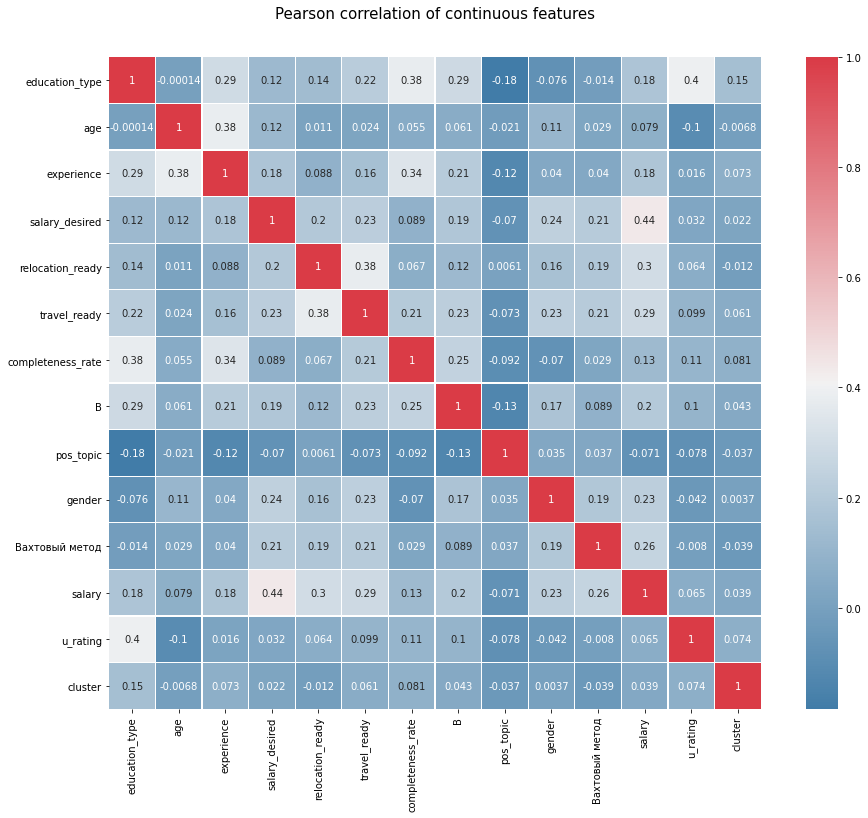

In [81]:
import seaborn as sns
from matplotlib import pyplot as plt
colormap = sns.diverging_palette( 240 , 10 , as_cmap = True )
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(attempt2.iloc[:,1:].corr(),linewidths=0.1,vmax=1.0, square=True,
cmap=colormap, linecolor='white', annot=True)
plt.show()

### Tuning of GB


In [82]:
attempt2.head(3)

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,salary,u_rating,cluster
0,0,3,21.0,3.0,35000.0,False,False,64.0,True,0,1,False,37500,493.0,8
1,1,4,26.0,4.0,15000.0,False,True,88.0,True,11,0,False,14000,380.0,4
2,3,4,36.0,12.0,20000.0,False,False,78.0,True,0,0,False,24600,0.0,0


In [83]:
#Разбиение
from sklearn.metrics import mean_squared_log_error
y = attempt2.iloc[:,-3]
X = attempt2.copy()
X = X.drop(columns=["salary",'u_rating'])
X =X.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [ ]:
#Здесь происходил масштабный тюнинг на 400 иттераций
from sklearn.ensemble import GradientBoostingRegressor

n_est=[50,100,150,200]
lr=[0.1,0.5,1,1.5,2]
md=[3,4,5,6,7]
mf=[2,5,8,11]

for i in n_est:
  for k in lr:
    for u in md:
      for s in mf:
        modelGB = GradientBoostingRegressor(loss='lad',random_state=0,
                                            n_estimators=i,learning_rate=k,
                                            max_depth=u,max_features=s)
        modelGB.fit(X_train, y_train)
        y_pred = modelGB.predict(X_test)
        y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)
        txt='RLSME: {},{},{},{}'
        print(txt.format(i,k,u,s),"- ",mean_squared_log_error(y_test, y_pred))

RLSME: 50,0.1,3,2 -  1.0764186789922743
RLSME: 50,0.1,3,5 -  1.0733776826379802
RLSME: 50,0.1,3,8 -  1.0731925079428515
RLSME: 50,0.1,3,11 -  1.072352513095138
RLSME: 50,0.1,4,2 -  1.07270279052685
RLSME: 50,0.1,4,5 -  1.0697767631440487
RLSME: 50,0.1,4,8 -  1.0698058726660946
RLSME: 50,0.1,4,11 -  1.0696042540200852
RLSME: 50,0.1,5,2 -  1.0696177074467446
RLSME: 50,0.1,5,5 -  1.0676499783872548
RLSME: 50,0.1,5,8 -  1.0671998795751436
RLSME: 50,0.1,5,11 -  1.0668516471758118
RLSME: 50,0.1,6,2 -  1.0676108909383708
RLSME: 50,0.1,6,5 -  1.065519235252978
RLSME: 50,0.1,6,8 -  1.0652378369522109
RLSME: 50,0.1,6,11 -  1.065009248166154
RLSME: 50,0.1,7,2 -  1.0652326072219347
RLSME: 50,0.1,7,5 -  1.0635007083639145
RLSME: 50,0.1,7,8 -  1.062496188781447
RLSME: 50,0.1,7,11 -  1.0628798411619618
RLSME: 50,0.5,3,2 -  1.0746787453472666
RLSME: 50,0.5,3,5 -  1.0714139728882084
RLSME: 50,0.5,3,8 -  1.0674356734173553
RLSME: 50,0.5,3,11 -  1.0671015954585281
RLSME: 50,0.5,4,2 -  1.0706933315206277


## Test  Solution



### Preprocess

In [85]:
#Снова родублируем данные, чтобы не перезагружать их заново, когда что-то в обработке пойдет не так
column_names = test.columns
tf=test[column_names]

#Для начала превратим категориальные переменные в дамми
#Водительские права
dl=[]
dl_cat = ['A','B','C','D','E']

for i in tf['drive_licences']:
    if type(i) is str:
        dl_i=[]
        for cat in dl_cat:
            if len(re.findall(r'{}'.format(cat),i))==0:
                dl_i.append(0)
            else:
                dl_i.append(1)
        dl.append(dl_i)
    else:
        dl.append([0,0,0,0,0])
a = pd.DataFrame(dl,columns=dl_cat)
        
for cat in dl_cat:
    tf[cat]=pd.Series(a[cat])


#График
dl=[]
dl_cat = ['Полный рабочий день',
'Сменный график',
'Неполный рабочий день',
'Гибкий график',
'Вахтовый метод',
'Ненормированный рабочий день']


for i in tf['schedule']:
    if type(i) is str:
        dl_i=[]
        for cat in dl_cat:
            if len(re.findall(r'{}'.format(cat),i))==0:
                dl_i.append(0)
            else:
                dl_i.append(1)
        dl.append(dl_i)
    else:
        dl.append([0,0,0,0,0,0])
a = pd.DataFrame(dl,columns=dl_cat)
        
for cat in dl_cat:
    tf[cat]=pd.Series(a[cat])
    
#Гражданство
no_problem=['Российская Федерация','Республика Казахстан','Республика Беларусь','Кыргызская Республика']
tf['bi_citi']= np.where((tf['citizenship'] == no_problem[0])|
                (tf['citizenship'] == no_problem[1])|
                (tf['citizenship'] == no_problem[2])|
                (tf['citizenship'] == no_problem[3]),1,0)

#Образование
tf['education_type']= np.where(tf['education_type'].isna(),'Not defined',tf['education_type'])
#т.к. есть порядок - используем лейблинг 
k=tf['education_type']
ed_code=[]
for i in k:
    if i =='Высшее':
        ed_code.append(4)
    elif i =='Незаконченное высшее':
        ed_code.append(3)
    elif i =='Среднее профессиональное':
        ed_code.append(2)
    elif i =='Среднее':
        ed_code.append(1)
    else:
        ed_code.append(0)
tf['education_type'] = ed_code

#Employment type и Industry
#т.к. порядка нет - прверащаем в дамми
s = pd.get_dummies(tf["employement_type"], prefix = "em_", drop_first=True)
s1 = pd.get_dummies(tf["industry"], drop_first=True)
s1.columns=['guard','top_mgmt','gos','mining','home','gkh','health','it','art','hr','consult','light','wood',
 'pr','mec_eng','metal','begin','edu','food_prom','sale','prod','no_qual','work_spec','eco','construc',
 'logist','travel','service','fin','chem','electro','law']
tf= tf.join(s)
tf= tf.join(s1)

#Возраст
age_median=tf['age'].median(skipna = bool)
tf['age']= np.where(tf['age'].isna(),age_median,tf['age'])
#Город
tf['locality_name']= np.where(tf['locality_name'].isna(),'Not defined',tf['locality_name'])
#Пол
k=tf['gender']
gender_code=[]
for i in k:
    if i =='Мужской':
        gender_code.append(1)
    elif i =='Женский':
        gender_code.append(0)
    else:
        gender_code.append(2)

tf['gender'] = gender_code

#Готовности к переезду/путшествиям/обучениям
tf['relocation_ready']= np.where(tf['relocation_ready'].isna(),False,tf['relocation_ready'])
tf['travel_ready']= np.where(tf['travel_ready'].isna(),False,tf['travel_ready'])
tf['retraining_ready']= np.where(tf['retraining_ready'].isna(),False,tf['retraining_ready'])
tf['completeness_rate']= np.where(tf['completeness_rate'].isna(),0,tf['completeness_rate'])

#Квалификация
tf['is_worldskills_participant']= np.where(tf['is_worldskills_participant'].isna(),False,True)
tf['has_qualifications']= np.where(tf['has_qualifications'].isna(),False,True)

tf=tf.drop(columns=['drive_licences','schedule','creation_date', 'modification_date', 'publish_date','locality'])

In [86]:
#Добавление топика для вакансии
#Position
k=tf['position']
l=[]
for i in k:
    l.append(i.split(",")[0].lower().replace('[^\w\s]','').strip())
    
from gensim import models
from gensim import corpora
import nltk

#Уберем ненужные символы, но не цифры
k_re=[]
for i in range(len(k)):
    result_k=re.findall(r'[А-я0-9]+',k[i])
    result_k=' '.join(result_k)
    k_re.append(result_k)

#Tokenizer через пробел
tokenizer = nltk.tokenize.WhitespaceTokenizer()
doc = [tokenizer.tokenize(job) for job in k_re]

#Lemmatize
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='ru')
doc_lem = [[morph.parse(token)[0].normal_form for token in title] for title in doc]


#Уберем стоп слова: предлоги,междометия, местоимения и т.д.
from nltk.corpus import stopwords
stopwords = set(stopwords.words('russian'))

jobs = [[word for word in job if word not in stopwords] for job in doc_lem]
jobs= [[word for word in job if (len(word)>1)|(re.findall(r'[А-я]',word)==[])] for job in jobs]

from gensim import corpora,models
#new_dictionary = corpora.Dictionary(jobs)
new_corpus = [dictionary.doc2bow(text) for text in jobs]
new_corpus_lsi=lsi[new_corpus]

topics=[]
s=0
for pos in new_corpus_lsi:
    weights=[]
    for topic in pos:
        weights.append(topic[1])
    if not weights:
        topics.append(0)
    else:
        index=weights.index(max(weights))
        topics.append(pos[index][0])
        
tf['pos_topic']=topics

In [87]:
#Объединяем все это в один датасет, проводим финальную чистку
test_attempt0=tf.drop(columns=['position','region','industry','locality_name','citizenship','employement_type'])

logs=['relocation_ready', 'travel_ready', 'retraining_ready','A', 'B', 'C', 'D', 'E', 
      'Полный рабочий день', 'Сменный график', 'Неполный рабочий день', 'Гибкий график', 'Вахтовый метод',
      'Ненормированный рабочий день', 'bi_citi', 'em__Полная занятость', 'em__Сезонная', 'em__Стажировка',
      'em__Удаленная', 'em__Частичная занятость', 'guard', 'top_mgmt', 'gos', 'mining', 'home', 'gkh', 'health',
      'it', 'art', 'hr', 'consult', 'light', 'wood', 'pr', 'mec_eng', 'metal', 'begin', 'edu', 'food_prom', 'sale',
      'prod', 'no_qual', 'work_spec', 'eco', 'construc', 'logist', 'travel', 'service', 'fin', 'chem', 'electro',
      'law']

for i in logs:
    test_attempt0[i] = test_attempt0[i].astype('bool')    

#Придется убрать резюме с ошибками, например, где люди указывали вместо зп (любой другой ожидаемой цифры), текст
age_median=test_attempt0['age'].median(skipna = bool)
test_attempt0['age']= pd.to_numeric(test_attempt0['age'],errors='coerce')
test_attempt0['age']= np.where(np.isnan(pd.to_numeric(test_attempt0['age'],errors='coerce')),age_median,test_attempt0['age'])

experience_median=test_attempt0['experience'].median(skipna = bool)
test_attempt0['experience']= pd.to_numeric(test_attempt0['experience'],errors='coerce')
test_attempt0['experience']= np.where(np.isnan(pd.to_numeric(test_attempt0['experience'],errors='coerce')),experience_median,test_attempt0['experience'])

sd_median=test_attempt0['salary_desired'].median(skipna = bool)
test_attempt0['salary_desired']= pd.to_numeric(test_attempt0['salary_desired'],errors='coerce')
test_attempt0['salary_desired']= np.where(np.isnan(pd.to_numeric(test_attempt0['salary_desired'],errors='coerce')),sd_median,test_attempt0['salary_desired'])
test_attempt0.head(3)

,id,education_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,A,B,C,D,E,Полный рабочий день,Сменный график,Неполный рабочий день,Гибкий график,Вахтовый метод,Ненормированный рабочий день,bi_citi,em__Полная занятость,em__Сезонная,em__Стажировка,em__Удаленная,em__Частичная занятость,guard,top_mgmt,gos,mining,home,gkh,health,it,art,hr,consult,light,wood,pr,mec_eng,metal,begin,edu,food_prom,sale,prod,no_qual,work_spec,eco,construc,logist,travel,service,fin,chem,electro,law,pos_topic
0,2,4,27.0,0,0.0,10288.0,False,True,True,False,False,86.0,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,7
1,6,0,34.0,2,0.0,56649.0,False,True,True,False,False,47.0,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
2,7,4,51.0,1,17.0,50000.0,False,False,True,False,False,66.0,True,True,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,7


In [88]:
#Оставляем отобранные переменные
test_attempt1=test_attempt0[chosen[:-1]].copy()
test_attempt1.head(3)

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод
0,2,4,27.0,0.0,10288.0,False,True,86.0,True,7,0,False
1,6,0,34.0,0.0,56649.0,False,True,47.0,False,0,2,False
2,7,4,51.0,17.0,50000.0,False,False,66.0,True,7,1,False


In [90]:
test_attempt1.to_csv('/content/drive/MyDrive/Hackaton/attempt1_test.csv', sep=',', index=False)

In [92]:
#Добавляем дополнительные данные по кластерам городов
t_cities=pd.read_csv('/content/drive/MyDrive/Hackaton/df_work_test.csv', sep=',')
t_cities=t_cities[['id','cluster']]
test_attempt2=test_attempt1.copy()
test_attempt2 = pd.merge(test_attempt2, cities, how='left', on="id")
test_attempt2.head(3)

,id,education_type,age,experience,salary_desired,relocation_ready,travel_ready,completeness_rate,B,pos_topic,gender,Вахтовый метод,cluster
0,2,4,27.0,0.0,10288.0,False,True,86.0,True,7,0,False,NaN
1,6,0,34.0,0.0,56649.0,False,True,47.0,False,0,2,False,NaN
2,7,4,51.0,17.0,50000.0,False,False,66.0,True,7,1,False,NaN


### Top Solution

In [95]:
#GB selected
#Гиперпараметры после пробега по 400 итерациям GB
y = attempt1.iloc[:,-1]
X = attempt1.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]
X_test=test_attempt1.iloc[:,1:]

from sklearn.ensemble import GradientBoostingRegressor
modelGB = GradientBoostingRegressor(loss='lad', n_estimators=150,learning_rate=0.2,max_depth=7,max_features=8,random_state=0)
modelGB.fit(X, y)
y_pred = modelGB.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

solution = test[['id']].copy()
solution['salary'] = pd.Series(y_pred)

In [98]:
solution.to_csv('my_solution1_GB_larg_tun_11.csv', sep=',', index=False)

### Other solutions

In [93]:
#GB selected
#Гиперпараметры
y = attempt1.iloc[:,-1]
X = attempt1.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]
X_test=test_attempt1.iloc[:,1:]

from sklearn.ensemble import GradientBoostingRegressor
modelGB = GradientBoostingRegressor(loss='lad', n_estimators=100,learning_rate=0.4,max_depth=5,random_state=0)
modelGB.fit(X, y)
y_pred = modelGB.predict(X_test)
y_pred=np.where(y_pred<0,y_pred.mean(),y_pred)

solution = test[['id']].copy()
solution['salary'] = pd.Series(y_pred)
solution.to_csv('my_solution1_GB_man_tun_11.csv', sep=',', index=False)

In [140]:
#GB selected
#Another loss function
y = attempt1.iloc[:,-1]
X = attempt1.copy()
X = X.drop(columns="salary")
X =X.iloc[:,1:]
X_test=test_attempt1.iloc[:,1:]

from sklearn.ensemble import GradientBoostingRegressor
modelGB = GradientBoostingRegressor(loss='lad', n_estimators=100)
modelGB.fit(X, y)
y_pred = modelGB.predict(X_test)

solution = test[['id']].copy()
solution['salary'] = pd.Series(y_pred)
solution.to_csv('my_solution1_GB_lad_11.csv', sep=',', index=False)

In [138]:
#Первая модель - дерево решений
solution = test[['id']].copy()
X =test_attempt0.iloc[:,1:]
pred = tree1.predict(X)
solution['salary'] = pd.Series(pred)
solution.to_csv('my_solution0.csv', sep=',', index=False)

In [ ]:
#GB по всем переменным
solution = test[['id']].copy()
X =test_attempt0.iloc[:,1:]
pred = modelGB.predict(X)
solution['salary'] = pd.Series(pred)
solution.to_csv('my_solutionGB.csv', sep=',', index=False)